# Version information

In [1]:
from datetime import date
print("Running date:", date.today().strftime("%B %d, %Y"))
import pyleecan
print("Pyleecan version:" + pyleecan.__version__)
import SciDataTool
print("SciDataTool version:" + SciDataTool.__version__)

Running date: May 06, 2022
Pyleecan version:1.3.7
SciDataTool version:1.4.24


# 전기 모듈을 사용하여 전류, 전압 및 토크를 계산하는 방법

이 튜토리얼은 전기 모듈을 사용하여 간단한 **전기적 등가 회로**를 사용하여 전류, 전압 및 토크를 계산하는 방법을 설명합니다. 아이디어는 다른 방법을 구현하는 방법에 대한 통찰력을 제공하는 것입니다.

이 튜토리얼을 검증하는 데 사용된 참조 자료는 Z. Yang, M. Krishnamurthy 및 I. P. Brown, "전체 토크 속도 범위에 걸친 IPM의 전자기 및 진동 특성", 2013 International Electric Machines & Drives Conference, Chicago, IL, 2013, pp 295-302, doi: 10.1109/IEMDC.2013.6556267.

## 기계 및 시뮬레이션 정의
이 튜토리얼은 "[머신을 정의하는 방법](https://pyleecan.org/tuto_Machine.html)" 튜토리얼에 정의된 머신 IPMSM_A(Prius 2004)를 사용합니다. 구성은 "[동작점 설정 방법](https://pyleecan.org/tuto_Operating_point.html)" 튜토리얼에서 사용한 것과 유사합니다.

<IPython.core.display.Javascript object>


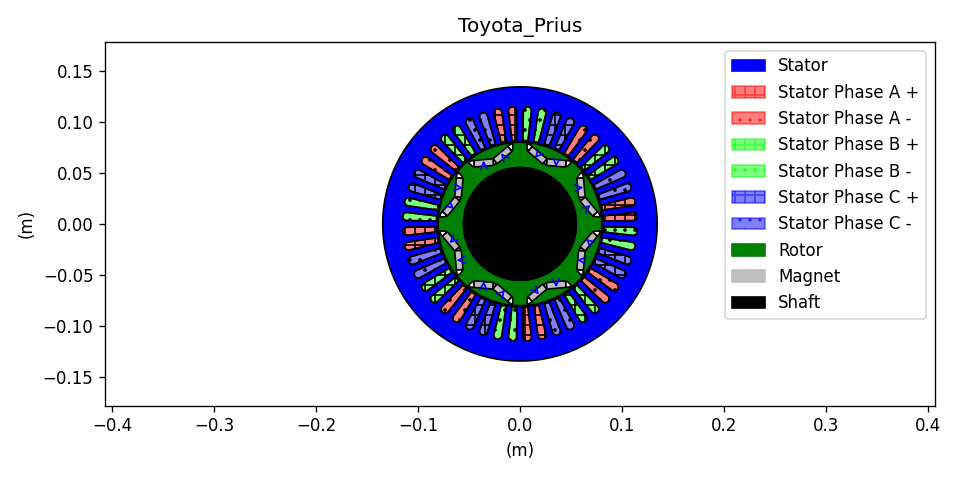

In [2]:
%matplotlib notebook

# Load the machine
from os.path import join
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR

Toyota_Prius = load(join(DATA_DIR, "Machine", "Toyota_Prius.json"))
Toyota_Prius.plot()

## 전기 등가 회로(EEC)
전기 모듈은 "Advanced Electrical Drives, analysis, modelling, control", Rik de doncker, Duco W.J. Pulle, Andre Veltman, Springer 에디션의 **전기적 등가 회로**에 해당하는 객체 EEC_PMSM으로 정의됩니다. Ud/Uq 또는 Id/Iq의 계산을 위한 것입니다(이하 도식 참조).

EEC의 매개변수는 먼저 'FluxLinkFEMM' 및 'IndMagFEMM' 개체에 따라 계산됩니다. FEMM 시뮬레이션(대칭 및 시간 단계 수 포함)을 사용하여 자속 결합 및 자기 인덕턴스를 계산할 수 있습니다. 자속 쇄교 계산을 위해 전류는 0A로 설정됩니다.

EEC의 매개변수가 알려지면 전압을 계산할 수 있습니다. 전기 토크는 다음 공식에 따라 계산됩니다. $T_{em}=\frac{P-RI^2}{\Omega}$, 여기서 $P$는 자기력 $P=\frac{q_s}{2 }\Re(VI^*)$

                 <---                               --->
     -----R-----wsLqIq----              -----R-----wsLdId----
    |                     |            |                     |
    |                     |            |                    BEMF
    |                     |            |                     |
     ---------Id----------              ---------Iq----------
             
             --->                               ---> 
              Ud                                 Uq

In [3]:
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.Electrical import Electrical
from pyleecan.Classes.EEC_PMSM import EEC_PMSM
from pyleecan.Classes.FluxLinkFEMM import FluxLinkFEMM
from pyleecan.Classes.IndMagFEMM import IndMagFEMM

# Initialization of the Simulation
simu = Simu1(name="tuto_elec", machine=Toyota_Prius)

# Definition of the magnetic simulation (FEMM with symmetry and sliding band)
simu.elec = Electrical(
    eec=EEC_PMSM(
        indmag=IndMagFEMM(is_periodicity_a=True, Nt_tot=50),
        fluxlink=FluxLinkFEMM(is_periodicity_a=True, Nt_tot=50),
    )
)
# Run only Electrical module
simu.mag = None
simu.force = None
simu.struct = None

## InputElec 또는 InputCurrent로 시작점 정의

시뮬레이션의 시작점은 InputElec 또는 InputCurrent로 정의됩니다. 이러한 개체는 "OutElec" 개체를 만들고 Id/Iq 및/또는 InputElec을 사용하여 Ud/Uq에 대해 제공된 값으로 초기화합니다. InputCurrent를 사용하면 시작점을 여러 가지 방법으로 정의할 수 있습니다("[동작점 설정 방법](https://pyleecan.org/tuto_Machine.html)" 참조).

Id/Iq는 자기 인덕턴스를 정확하게 계산하는 데 필요하므로 Ud/Uq만 제공되는 경우 전류 Id=1A 및 Iq=1A가 Ld 및 Lq 계산에 사용됩니다. 보다 만족스러운 방법은 Id/Iq에 대한 Ld 및 Lq의 맵을 계산하는 것입니다. 미래의 발전은 환영받을 것입니다.

In [4]:
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.OPdq import OPdq
from numpy import sqrt, exp, pi

# Definition of a sinusoidal current
simu.input = InputCurrent()

I0_rms = 250/sqrt(2) # Maximum current [Arms]
Phi0 = 140*pi/180  # Maximum Torque Per Amp

Id_ref = (I0_rms*exp(1j*Phi0)).real
Iq_ref = (I0_rms*exp(1j*Phi0)).imag



## Running the simulation and postprocessings

In [5]:
# Setting the values
simu.input.OP = OPdq(Id_ref=Id_ref, Iq_ref=Iq_ref)

(Id_ref,Iq_ref)

simu.input.Nt_tot = 50 # Number of time steps
simu.input.Na_tot = 2048 # Spatial discretization
simu.input.OP.N0 = 2000 # Rotor speed [rpm]



In [6]:
out = simu.run()

[13:23:46] Starting running simulation tuto_elec (machine=Toyota_Prius)
[13:23:46] Starting Electric module
[13:23:46] Compute flux linkage with FEMM
[13:23:46] Starting running simulation tuto_elec_FluxLinkFEMM (machine=Toyota_Prius)
[13:23:46] Starting Magnetic module
[13:23:46] In Magnetic model, Nt_tot=50 is not divisible by the machine time periodicity (4). Time periodicity removed
[13:23:47] Solving time step 1 / 50 in FEMM
[13:23:48] Solving time step 2 / 50 in FEMM
[13:23:49] Solving time step 3 / 50 in FEMM
[13:23:49] Solving time step 4 / 50 in FEMM
[13:23:50] Solving time step 5 / 50 in FEMM
[13:23:50] Solving time step 6 / 50 in FEMM
[13:23:51] Solving time step 7 / 50 in FEMM
[13:23:51] Solving time step 8 / 50 in FEMM
[13:23:52] Solving time step 9 / 50 in FEMM
[13:23:52] Solving time step 10 / 50 in FEMM
[13:23:53] Solving time step 11 / 50 in FEMM
[13:23:53] Solving time step 12 / 50 in FEMM
[13:23:54] Solving time step 13 / 50 in FEMM
[13:23:54] Solving time step 14 / 

In [26]:
print(out.elec.OP.get_Ud_Uq())
print("Tem: "+str(out.elec.Tem_av_ref))

{'Ud': -201.19069064243243, 'Uq': -12.281483461912348}
Tem: 354.0116083304767


<IPython.core.display.Javascript object>


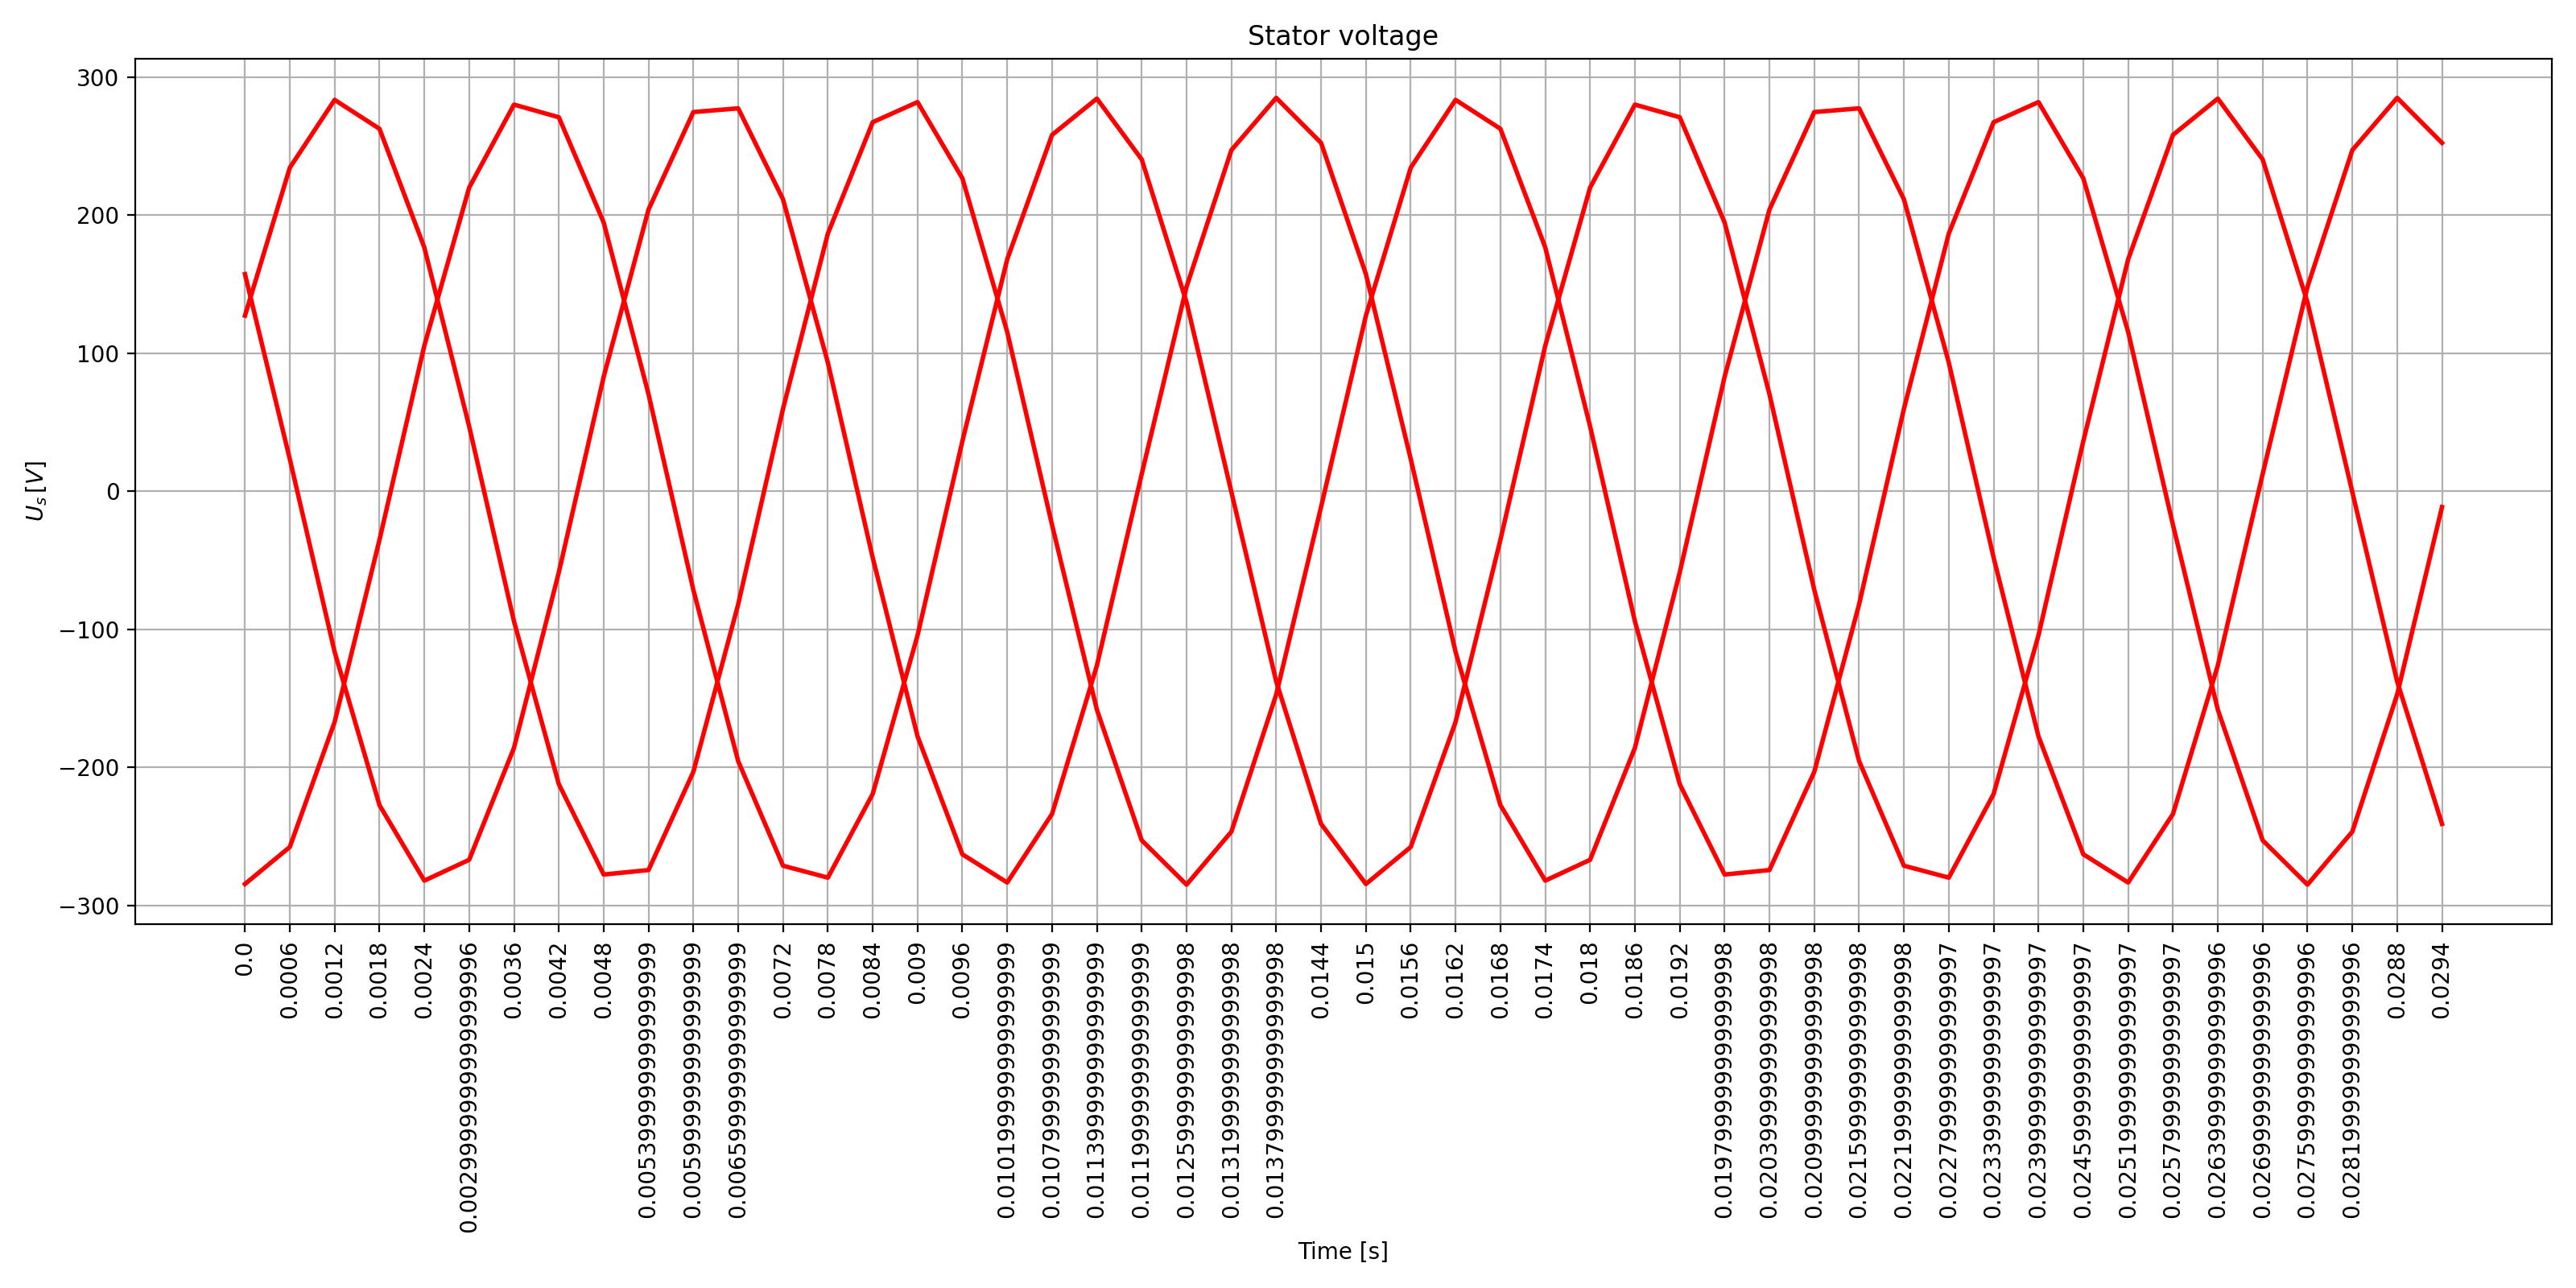

In [69]:
# Plot the voltages

out.elec.get_Us().plot_2D_Data("time", "phase", **dict_2D)

<IPython.core.display.Javascript object>


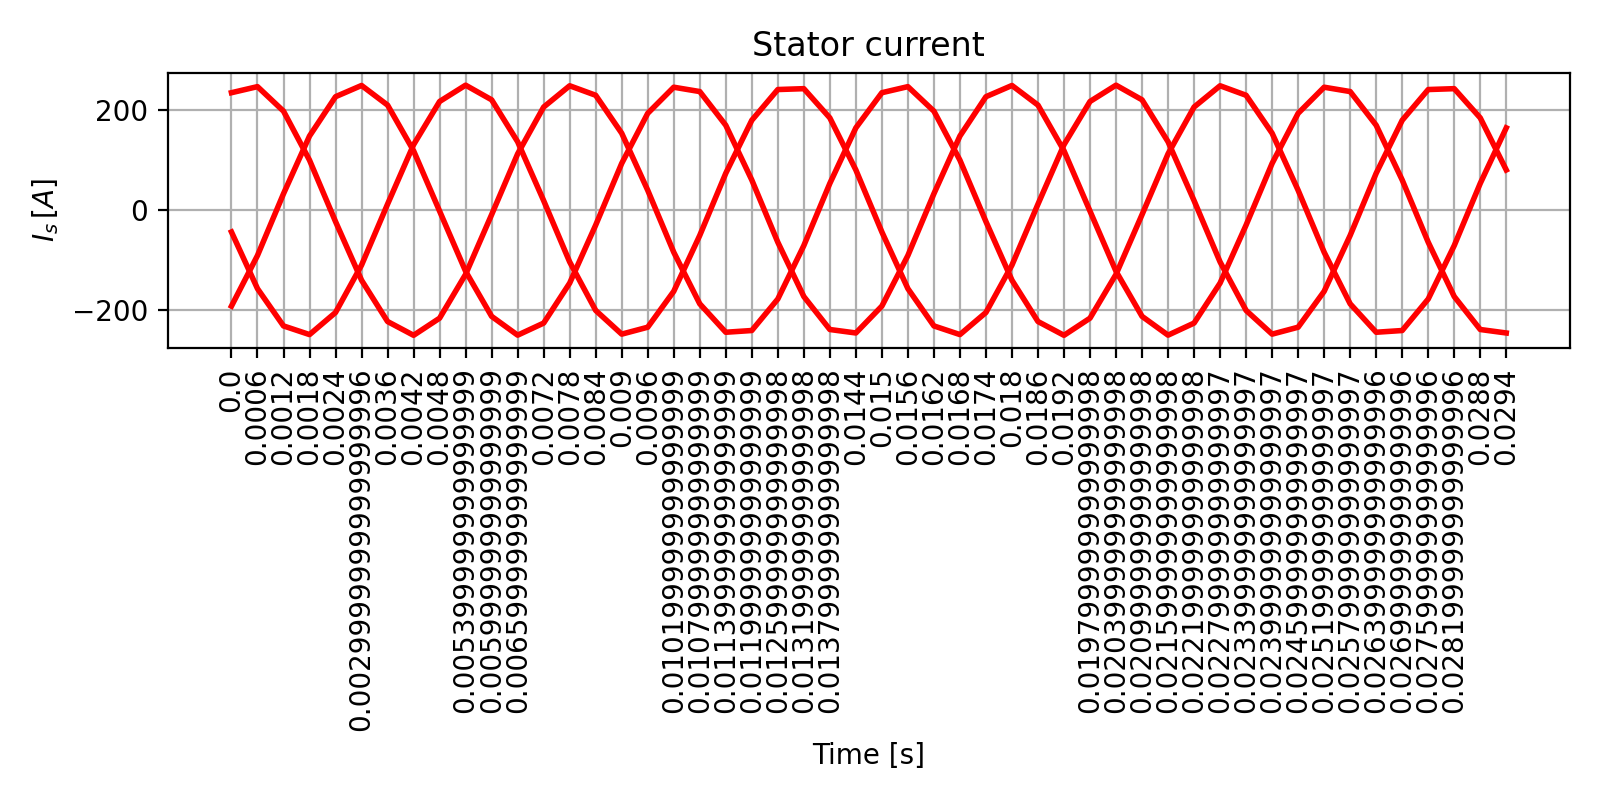

In [77]:
from pyleecan.Functions.Plot import dict_2D
# Plot the currents
out.elec.get_Is().plot_2D_Data("time", "phase", **dict_2D)

## 여러 운전 지점에서 반복
기준 토크 및 현재 각도 벡터는 다음과 같습니다.

In [78]:
from numpy import linspace, array, pi
Tem_av_ref = array([79, 125, 160, 192, 237, 281, 319, 343, 353, 332, 266, 164, 22]) # Yang et al, 2013
Phi0_ref = linspace(60 * pi / 180, 180 * pi / 180, Tem_av_ref.size)
N_simu = Tem_av_ref.size


In [76]:
import numpy as np
from matplotlib import pyplot as plt



다중 시뮬레이션은 "[동작점 설정 방법](https://pyleecan.org/tuto_Machine.html)"에서 설명한 것과 유사하지만, 이제 자기 토크 대신 전기 토크를 계산한다는 점만 다릅니다.

In [52]:
from pyleecan.Classes.VarLoadCurrent import VarLoadCurrent
from numpy import zeros, ones, linspace, array, sqrt, arange

varload = VarLoadCurrent(is_torque=True)
varload.type_OP_matrix = 0 # Matrix N0, I0, Phi0

# Creating the Operating point matrix
OP_matrix = zeros((N_simu,4))

# Set N0 = 2000 [rpm] for all simulation
OP_matrix[:,0] = 2000 * ones((N_simu))

# Set I0 = 250 / sqrt(2) [A] (RMS) for all simulation
OP_matrix[:,1] = I0_rms * ones((N_simu)) 

# Set Phi0 from 60° to 180°
OP_matrix[:,2] = Phi0_ref

# Set reference torque from Yang et al, 2013
OP_matrix[:,3] = Tem_av_ref

varload.OP_matrix = OP_matrix
print(OP_matrix)



[[2.00000000e+03 1.76776695e+02 1.04719755e+00 7.90000000e+01]
 [2.00000000e+03 1.76776695e+02 1.22173048e+00 1.25000000e+02]
 [2.00000000e+03 1.76776695e+02 1.39626340e+00 1.60000000e+02]
 [2.00000000e+03 1.76776695e+02 1.57079633e+00 1.92000000e+02]
 [2.00000000e+03 1.76776695e+02 1.74532925e+00 2.37000000e+02]
 [2.00000000e+03 1.76776695e+02 1.91986218e+00 2.81000000e+02]
 [2.00000000e+03 1.76776695e+02 2.09439510e+00 3.19000000e+02]
 [2.00000000e+03 1.76776695e+02 2.26892803e+00 3.43000000e+02]
 [2.00000000e+03 1.76776695e+02 2.44346095e+00 3.53000000e+02]
 [2.00000000e+03 1.76776695e+02 2.61799388e+00 3.32000000e+02]
 [2.00000000e+03 1.76776695e+02 2.79252680e+00 2.66000000e+02]
 [2.00000000e+03 1.76776695e+02 2.96705973e+00 1.64000000e+02]
 [2.00000000e+03 1.76776695e+02 3.14159265e+00 2.20000000e+01]]


<function ndarray.item>

In [79]:
# Run multisimulation
simu2 = simu.copy()
simu2.var_simu = varload
Xout = simu2.run()

[02:53:50] Starting running simulation tuto_elec (machine=Toyota_Prius)
[02:53:50] Reference Operating point is not in OP_matrix, one extra simulation will be computed
[02:53:50] Computing reference simulation for Variable Load
[02:53:50] Starting Electric module
[02:53:50] Variable Load Reference Results: N0=2000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms], I0=176.8 [A], Phi0=2.443 [], Tem_av_ref=354 [N.m]
[===                                               ]   7%
[02:53:50] Running simulation 1/13 with N0=2000 [rpm], Id=88.39 [Arms], Iq=153.1 [Arms]
[02:53:50] Starting Electric module
[02:53:50] Variable Load Results: N0=2000 [rpm], Id=88.39 [Arms], Iq=153.1 [Arms], I0=176.8 [A], Phi0=1.047 [], Tem_av_ref=-284.5 [N.m]
[=======                                           ]  14%
[02:53:50] Running simulation 2/13 with N0=2000 [rpm], Id=60.46 [Arms], Iq=166.1 [Arms]
[02:53:50] Starting Electric module
[02:53:50] Variable Load Results: N0=2000 [rpm], Id=60.46 [Arms], Iq=166.1 [Arms], I0=176.8 

Once the simulation is done, the torque as a function of Phi0 can be plotted with:

<IPython.core.display.Javascript object>


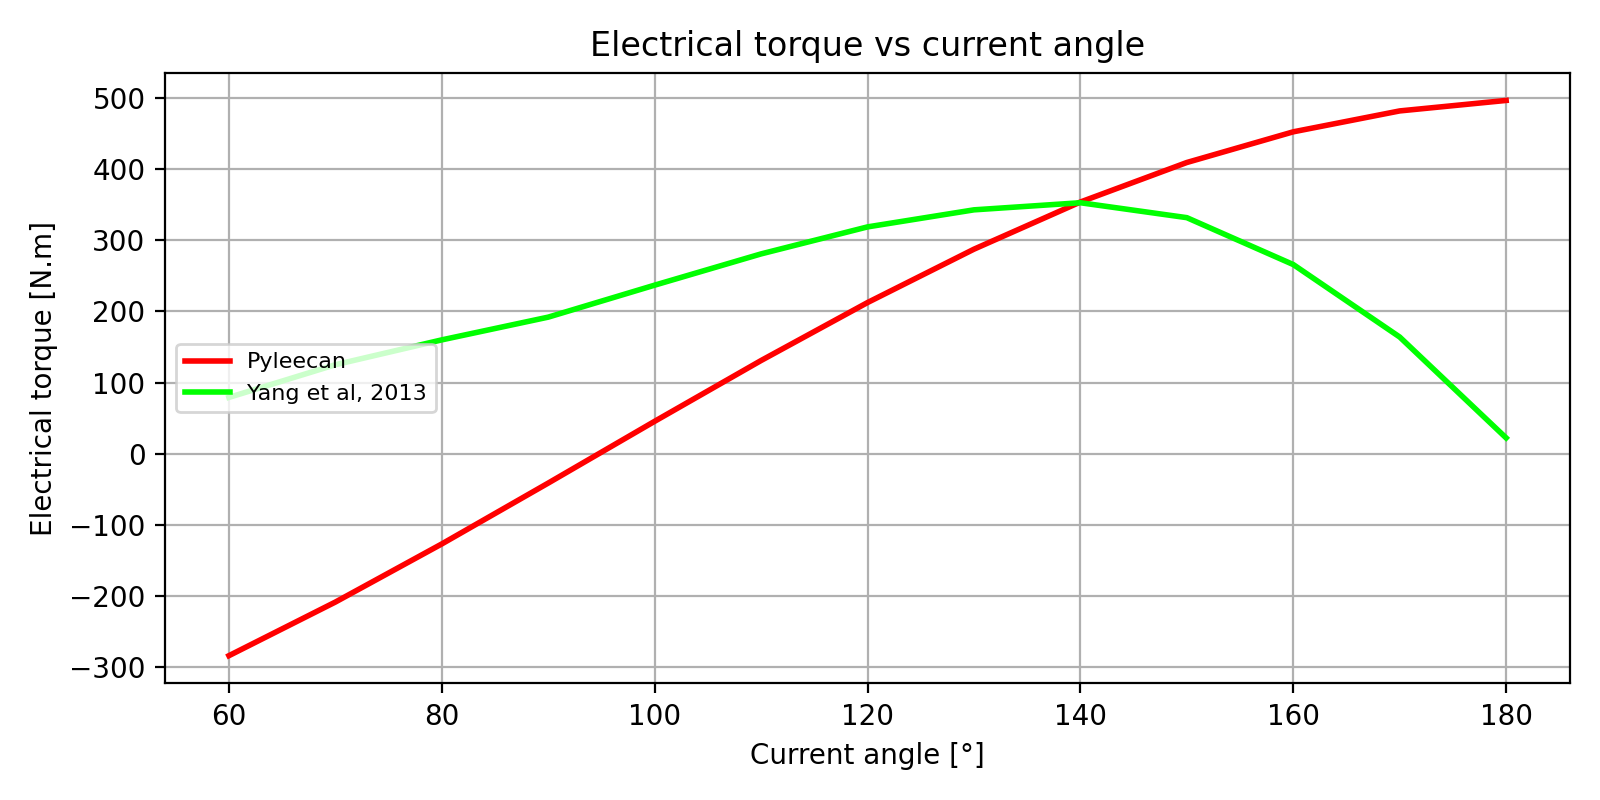

In [80]:
# Plot torque as a function of Phi0
from SciDataTool.Functions.Plot.plot_2D import plot_2D
from numpy import array

plot_2D(
    array([x*180/pi for x in Xout.xoutput_dict["Phi0"].result]),
    [Xout.xoutput_dict["Tem_av_ref"].result, Tem_av_ref],
    legend_list=["Pyleecan", "Yang et al, 2013"],
    xlabel="Current angle [°]",
    ylabel="Electrical torque [N.m]",
    title="Electrical torque vs current angle",
    **dict_2D
)